# Amazon Product Reviews - Improving helpfulness rating

In this project, I am predicting the helpfulness of product reviews for __cell phones and accessories__ category on Amazon. This data set contains Amazon review data from May 1996 - July 2014.

The prediction can help improve Amazon's placement of helpful reviews at the top and also improve customer's purchasing decisions.

[Amazon Data Link](http://jmcauley.ucsd.edu/data/amazon/)

In [4]:
# Load the json file in the form of a dataframe
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    #if i % 10000 == 0:
        #print(i)
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

review_df = getDF('reviews_Cell_Phones_and_Accessories_5.json.gz')

In [5]:
# Explore the review text
review_df.head()

,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",1400630400,They look good and stick good! I just don't li...,4.0,"05 21, 2014",Looks Good
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",1389657600,These stickers work like the review says they ...,5.0,"01 14, 2014",Really great product.
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",1403740800,These are awesome and make my phone look so st...,5.0,"06 26, 2014",LOVE LOVE LOVE
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",1382313600,Item arrived in great time and was in perfect ...,4.0,"10 21, 2013",Cute!
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]",1359849600,"awesome! stays on, and looks great. can be use...",5.0,"02 3, 2013",leopard home button sticker for iphone 4s


In [6]:
# Basic statistics about the Cell Phones
unique_users = set(review_df['reviewerID'])
unique_items = set(review_df['asin'])

print "The total number of reviews in this dataset: ", len(review_df)
print "The total number of users: ", len(unique_users)
print "The total number of items: ", len(unique_items)

The total number of reviews in this dataset:  194439
The total number of users:  27879
The total number of items:  10429


In [7]:
# Select a review for analysis dataset if it has atleast two people who have rated it

def selectreview(helpful):
    return helpful[1] >= 2

review_df['select_review'] = review_df['helpful'].map(selectreview)
selected_review_df = review_df[review_df['select_review'] == True]

# Number of selected reviews for the analysis
print("Number of selected reviews for analysis = %d"%len(selected_review_df))

Number of selected reviews for analysis = 28126


In [8]:
import warnings
warnings.simplefilter('ignore')

# Calculate helpfulness ratio
def helpfulratio(helpful):   
    return float(helpful[0])/float(helpful[1])

# Label a review as helpful if atleast 80% of people have rated it as helpful
def label(ratio):    
    return ratio >= 0.8
    
selected_review_df['helpful_ratio'] = selected_review_df['helpful'].map(helpfulratio)
selected_review_df['helpful_label'] = selected_review_df['helpful_ratio'].map(label)

print("Number of reviews labeled as helpful = %d"%len(selected_review_df[selected_review_df['helpful_label']==True]))

Number of reviews labeled as helpful = 13902


In [9]:
from textstat.textstat import textstat
import re

# Calculate flesch readability score
def flesch_readability(text):
    return textstat.flesch_reading_ease(text) if text else 100

# Calculate automated readability score
def automated_readability(text):
    return textstat.automated_readability_index(text) if text else 1

# Find the number of capital letters (indicate extreme emotion)
def count_caps(text):    
    return len(re.findall(r'[A-Z]',text)) if text else 0

# Find the number of exclamation and question marks
def count_ex(text):          
    return len(re.findall(r'[!?]',text)) if text else 0

selected_review_df['flesch_read'] = selected_review_df['reviewText'].map(flesch_readability)
selected_review_df['automated_read'] = selected_review_df['reviewText'].map(automated_readability)
selected_review_df['num_caps'] = selected_review_df['reviewText'].map(count_caps)
selected_review_df['num_excl'] = selected_review_df['reviewText'].map(count_ex)

In [10]:
import string

# Lowercase all text
def lower_case(text):            
    return text.lower()

# Remove punctuation marks
def remove_punctuation(text):     
    return text.translate(None, string.punctuation.translate(None, '"'))

# Calculate the length of review in number of words
def count_len(text):     
    return len(text.split())

selected_review_df['reviewText_lower'] = selected_review_df['reviewText'].apply(lambda x: lower_case(x))
selected_review_df['reviewText_clean'] = selected_review_df['reviewText_lower'].apply( lambda x: remove_punctuation(x))
selected_review_df['length_words'] = selected_review_df['reviewText_clean'].map(count_len)

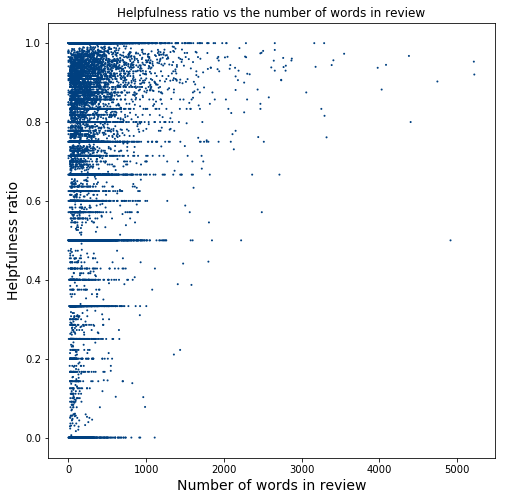

In [11]:
import matplotlib.pyplot as plt

# Plot the helpfulness ratio vs. the number of words in review
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

plt.scatter(selected_review_df['length_words'], selected_review_df['helpful_ratio'], s=1, marker='o',
            facecolors='none', edgecolors = '#004080')

ax.set_title('Helpfulness ratio vs the number of words in review')
ax.set_ylabel('Helpfulness ratio', fontsize=14)
ax.set_xlabel('Number of words in review', fontsize=14)
plt.show()

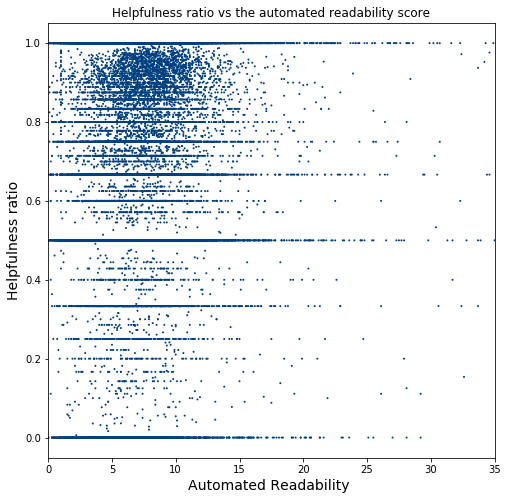

In [12]:
# Plot the readability score vs. the number of words
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

plt.scatter(selected_review_df['automated_read'], selected_review_df['helpful_ratio'], s=1, marker='o',
            facecolors='none', edgecolors = '#004080')

ax.set_title('Helpfulness ratio vs the automated readability score')
ax.set_ylabel('Helpfulness ratio', fontsize=14)
ax.set_xlabel('Automated Readability ', fontsize=14)
ax.set_xlim([0,35])
plt.show()

In [13]:
# Shuffle the dataframe
result = selected_review_df.sample(frac=1).reset_index(drop=True)

# Split the dataframe into training and test data
train_len = int(0.8 * len(result))
test_len = len(result) - train_len

REVIEWER_ID = 'reviewerID'

# Calculate the average helpfulness ratio for reviews written by each user
def reviewer_attribute_mean(uid, data, attr, prefix_length):
    values = data.head(prefix_length)[data[REVIEWER_ID] == uid][attr]
    return values.mean() if len(values) > 0 else 0.0

# Find distinct reviewers in the dataset.
reviewer_df = pd.DataFrame({REVIEWER_ID: result[REVIEWER_ID].unique()})
reviewer_df['reviewer_ratio'] = reviewer_df[REVIEWER_ID].map(lambda uid: reviewer_attribute_mean(uid,
                                                            result, 'helpful_ratio', train_len))
reviewer_df['reviewer_label'] = reviewer_df[REVIEWER_ID].map(lambda uid: reviewer_attribute_mean(uid,
                                                            result, 'helpful_label', train_len))

train_test_df = pd.merge(result, reviewer_df, how='left', on=REVIEWER_ID)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
import numpy, scipy.sparse
from sklearn.decomposition import TruncatedSVD

stemmer = SnowballStemmer('english')

def tokens(x):
    return [stemmer.stem(word) for word in x.split()]

vectorizer = TfidfVectorizer(tokenizer=tokens, encoding='utf-8', max_df = 0.80, stop_words='english',
                             ngram_range=(1, 1))
tfidf = vectorizer.fit_transform(train_test_df['reviewText_clean'])
svd_matrix = TruncatedSVD(n_components=200).fit_transform(tfidf)

In [25]:
features_to_keep = ['flesch_read', 'automated_read','num_caps', 'num_excl', 'length_words', 'overall',
                    'reviewer_ratio', 'reviewer_label'] 

direct_features = train_test_df.loc[:,features_to_keep].as_matrix()
joined_features = numpy.concatenate((direct_features, svd_matrix), axis=1)

print(svd_matrix.shape)
print(direct_features.shape)
print(joined_features.shape)

(28126, 200)
(28126, 8)
(28126, 208)


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from time import time
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score

train_X = joined_features[:train_len]
test_X = joined_features[test_len:]
train_Y = train_test_df['helpful_label'].iloc[:train_len]
test_Y = train_test_df['helpful_label'].iloc[test_len:]

RAN_STATE = 40

def train_predict(clf, train_f, train_lab, test_f, test_lab):
    
    # Start the clock, train the classifier, then stop the clock
    print ("Training a {} classifier . .".format(clf.__class__.__name__))
    start = time()
    clf.fit(train_f, train_lab)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))
    
    start = time()
    # Predictions on test data
    pred = clf.predict(test_f)
    end = time()
    print ("Made predictions in {:.4f} seconds ".format(end - start))
    roc = roc_auc_score(test_lab, pred)
    print("ROC-AUC score for {} classifier: {:.4f}".format (clf.__class__.__name__,roc))
    f1 = f1_score(test_lab, pred)
    print("F1 score for {} classifier: {:.4f}\n".format (clf.__class__.__name__,f1))

clf_list = [GaussianNB(), 
            AdaBoostClassifier(random_state = RAN_STATE),
            LogisticRegression(random_state = RAN_STATE),
            RandomForestClassifier(random_state = RAN_STATE)]

for classifier in clf_list:
    train_predict(classifier, train_X, train_Y, test_X, test_Y)

 Training a GaussianNB classifier
Trained model in 0.1181 seconds
Made predictions in 0.1213 seconds 
ROC-AUC score for GaussianNB classifier: 0.7679
F1 score for GaussianNB classifier: 0.7616

Training a AdaBoostClassifier classifier
Trained model in 31.5091 seconds
Made predictions in 0.2158 seconds 
ROC-AUC score for AdaBoostClassifier classifier: 0.7860
F1 score for AdaBoostClassifier classifier: 0.7768

Training a LogisticRegression classifier
Trained model in 3.5285 seconds
Made predictions in 0.0051 seconds 
ROC-AUC score for LogisticRegression classifier: 0.7831
F1 score for LogisticRegression classifier: 0.7734

Training a RandomForestClassifier classifier
Trained model in 3.2115 seconds
Made predictions in 0.0580 seconds 
ROC-AUC score for RandomForestClassifier classifier: 0.8858
F1 score for RandomForestClassifier classifier: 0.8794



Random Forest Classifier gives the highest ROC-AUC score. I will go into more detail with Random Forest since it performed the best relative to the other classifiers.

In [56]:

rfc = RandomForestClassifier(random_state = RAN_STATE)
rfc.fit(train_X, train_Y)
pred = rfc.predict(test_X)
print "Random Forest Classifier"
print "Accuracy", accuracy_score(test_Y, pred)
print "ROC-AUC", roc_auc_score(test_Y, pred)
print "F1", f1_score(test_Y, pred)
print "Recall", recall_score(test_Y, pred)
print "Precision", precision_score(test_Y, pred)
print "Confusion Matrix\n", confusion_matrix(test_Y, pred)


Random Forest Classifier
Accuracy 0.886311111111
ROC-AUC 0.885816869545
F1 0.879430618401
Recall 0.837883959044
Precision 0.925312438008
Confusion Matrix
[[10613   753]
 [ 1805  9329]]


In [49]:
from IPython.display import display

importances = pd.DataFrame({'feature':features_to_keep, 'importance':np.round(rfc.feature_importances_[:8],3)})
importances = importances.sort_values('importance', ascending=False).set_index('feature')
display(importances)


Importances of the features


,importance
feature,
reviewer_label,0.349
reviewer_ratio,0.135
overall,0.029
length_words,0.006
num_caps,0.004
flesch_read,0.002
automated_read,0.002
num_excl,0.001


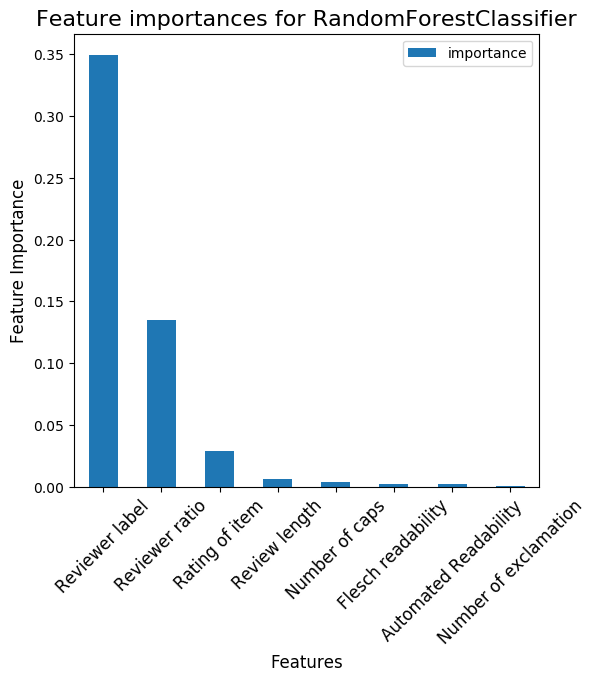

In [62]:
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
fig.set_dpi(100)

importances.plot.bar(ax=ax,)
ax.set_ylabel('Feature Importance', fontsize=12)
ax.set_xlabel('Features', fontsize=12)
ax.set_xticklabels(['Reviewer label','Reviewer ratio', 'Rating of item', 
                    'Review length','Number of caps','Flesch readability','Automated Readability',
                    'Number of exclamation'], rotation=45, fontsize=12)
ax.set_title('Feature importances for RandomForestClassifier', fontsize=16)
plt.show()